In [3]:
from sklearn.datasets import load_iris
import pandas as pd
import pdb
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [10]:
import numpy as np
np.random.seed(seed=0)
n_samples = 100
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
y = y+1
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [11]:
y

array([2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2])

In [44]:
class ScratchDecesionTreeClassifierDepth():
    
    def __init__(self, max_depth=3):
        self.left = None
        self.right = None
        self.max_depth = max_depth
        self.X = None
        self.y = None
        self.depth = None
        self.threshold = None
        self.feature = None
        self.gini_min = None
        self.label = None
        
    def gini_score(self, X, y, feat_idx, threshold):
        g1 = 0
        gini_total = 0
        
        for i in np.unique(y):
            g1 += (np.sum(y==i) / len(y))**2
        gini_total += 1 - g1
        
        sample_num = len(y)
        div_y = [y[X[:, feat_idx] >= threshold], y[X[:, feat_idx] < threshold]]
        for group in div_y:
            score = 0
            classes = np.unique(group)
            for cls in classes:
                p = np.sum(group == cls)/len(group)
                score += p * p
            gini_total -= (1- score) * (len(group)/sample_num)
        return gini_total

    def search_best_split(self, X, y):   
        features = X.shape[1]
        best_threshold = None
        best_feature = None
        gini_best = 0

        for feat_idx in range(features):
            values = X[:, feat_idx]
            for val in values:
                gini = self.gini_score(X, y, feat_idx, val)
                if gini_best < gini:
                    gini_best = gini
                    best_threshold = val
                    best_feature = feat_idx
        return gini_best, best_threshold, best_feature       
    
    def split(self, X, y, depth):
        self.X = X
        self.y = y
        self.label = np.argmax(np.bincount(self.y))
        self.depth = depth
        self.gini_best, self.threshold, self.feature = self.search_best_split(self.X, self.y)
        print('Depth: {}, Sep at Feature: {},Threshold: {}, Label: {}'.format(self.depth, self.feature, self.threshold, self.label))
        
        if self.depth == self.max_depth or self.gini_best == 0:
            return       
        idx_left = self.X[:, self.feature] >= self.threshold
        idx_right = self.X[:, self.feature] < self.threshold
        
        self.left = ScratchDecesionTreeClassifierDepth(self.max_depth)
        self.right = ScratchDecesionTreeClassifierDepth(self.max_depth)
        self.left.split(self.X[idx_left],  self.y[idx_left], self.depth +1)
        self.right.split(self.X[idx_right], self.y[idx_right], self.depth +1)
    
    def node_predict(self, X):
        if self.gini_best == 0.0 or self.depth == self.max_depth:
            return self.label
        else:
            if X[self.feature] > self.threshold:
                return self.left.node_predict(X)
            else:
                return self.right.node_predict(X)        
    
    def fit(self, X, y):
        initial_depth = 0
        self.split(X, y, initial_depth)
    
    def predict(self, X):
        pred = []
        for s in X:
            pred.append(self.node_predict(s))
        return np.array(pred)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
clf = ScratchDecesionTreeClassifierDepth(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = sum(y_pred == y_test)/float(len(y_test))
print('Classification accuracy: {}'.format(score))

Depth: 0, Sep at Feature: 1,Threshold: 0.5177153978980351, Label: 0
Depth: 1, Sep at Feature: 0,Threshold: 2.498295595463077, Label: 2
Depth: 2, Sep at Feature: None,Threshold: None, Label: 0
Depth: 2, Sep at Feature: None,Threshold: None, Label: 2
Depth: 1, Sep at Feature: 0,Threshold: -0.5595202829694812, Label: 0
Depth: 2, Sep at Feature: None,Threshold: None, Label: 0
Depth: 2, Sep at Feature: None,Threshold: None, Label: 2
Classification accuracy: 1.0


In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

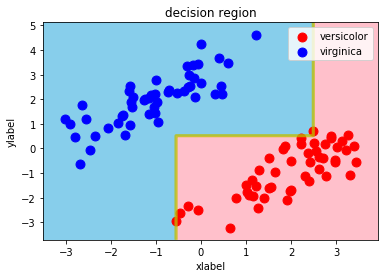

In [47]:
decision_region(X, y, clf)